## [Computational Social Science] Project 5: Natural Language Processing
**Group 3: Jose Aveldanes, Shruti Bathia, and Diana Casanova**

## 1. Introduction
In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#LDA Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation , NMF

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#WordCloud for EDA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#removing emojis
import re

#import emoji
#import scattertext as st

##machine learning and classification part 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

## 2. Data

In [2]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()
numpy.random.seed(44)
congress_tweets = congress_tweets.sample(frac=0.001, random_state=1)
congress_tweets.head()
# COMPLETE - fill in this line of code with a sufficient number of tweets, depending on your computational resources
# COMPLETE congress_tweets = congress_tweets.sample(...)

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
217331,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
258764,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
50091,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
205601,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
85993,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


## 3. Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
nlp = en_core_web_sm.load()

In [4]:
def remove_emojis(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" #emoticons  
        u"\U0001F300-\U0001F5FF" #symbols & pictographs 
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #flags(iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"   
        "]+", 
        flags=re.UNICODE,)
    return emoji_pattern.sub(r"", string)

In [5]:
congress_tweets['text_deEmojify'] = congress_tweets['text'].map(lambda x: remove_emojis(x))

In [6]:
print(congress_tweets.iloc[5]['text_deEmojify']) #checking to see if emojis were removed

RT @Johnson4Dallas This is the most accurate description of the current City of Dallas budget debate (and surrounding noise) that I have read thus far. Kudos to the author for helping to arm the residents of Dallas with actual facts instead of useless political gossip. https://texasscorecard.com/commentary/montoya-citizens-matter-not-city-hall-brawls/


In [7]:
#Removing new line
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('\n','')
#Removing New Line Breaks
congress_tweets["text_deEmojify"] = congress_tweets["text_deEmojify"].str.replace('•','')

In [8]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words |= {"amp", "RT", "today", "rt", "Today"}
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [9]:
congress_tweets['tokens'] = congress_tweets['text_deEmojify'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

217331    [Thank, testifying, Mr, Blake, QT, JRBlake, Re...
258764    [My, Twitter, Town, Hall, healthcare, begun, I...
50091     [Scipio, Jones, ‘, fight, civil, rights, equal...
205601    [There, better, time, ActOnClimate, EarthDay, ...
85993     [I, understand, VA, problems, recruiting, qual...
                                ...                        
849015    [Thank, air, traffic, controllers, flight, att...
402238    [LawrenceGenHosp, new, coronavirus, community,...
349360    [senatemajldr, If, House, musters, courage, st...
65615     [It, important, support, policies, promote, pu...
356055    [davidmgoodwin, CDCgov, It, argument, giving, ...
Name: tokens, Length: 947, dtype: object

In [10]:
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))

In [11]:
#lemmatization
#for word in nlp(text):
    #print(word.text,  word.lemma_)

## 4. Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: N-Grams

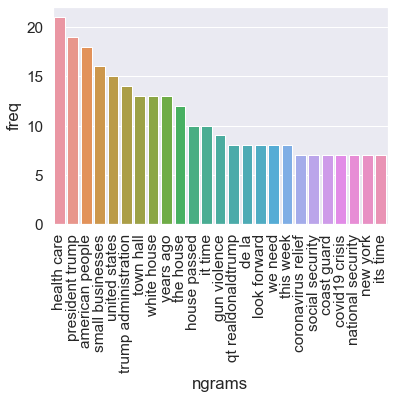

In [88]:
countvec = CountVectorizer(ngram_range=(2,2))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head()

sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

### EDA 2: Word Cloud

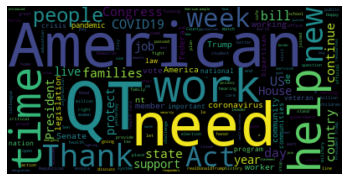

In [12]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### EDA 3: Length and Word Count

In [13]:
congress_tweets['tweet_len'] = congress_tweets['text_deEmojify'].apply(len)
congress_tweets['word_count'] = congress_tweets['text_deEmojify'].apply(lambda x: len(str(x).split()))

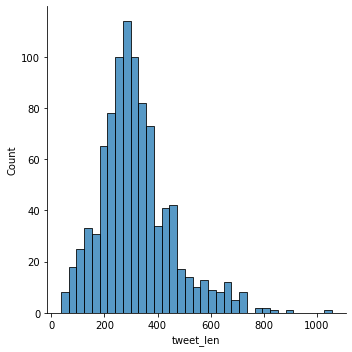

In [14]:
sns.displot(congress_tweets, x="tweet_len")
plt.show()

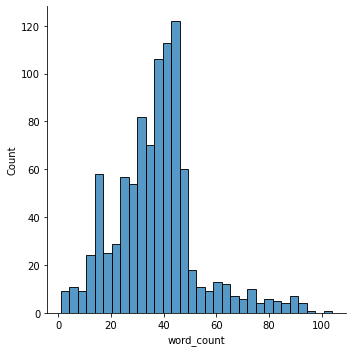

In [15]:
sns.displot(congress_tweets, x="word_count")
plt.show()

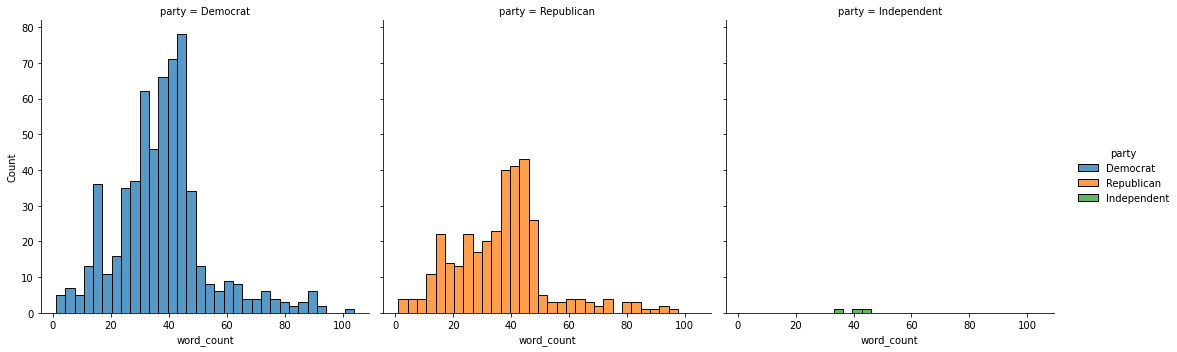

In [16]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "party")
plt.show()

### Topic Modeling

In [17]:
X = congress_tweets['text_deEmojify']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [18]:
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [19]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [20]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
  work need week covid19 help jobs de country community happy thank congress americans care district people qt time trump

Topic #1:
  new health house qt “ president trump american administration ” workers congress covid19 continue work democrats veterans families week

Topic #2:
  act americans help new house qt work trump system president care important ’ ago health people thank senate 2020census

Topic #3:
  qt trump time need people families covid19 coronavirus president relief new act thank house nt read law — american

Topic #4:
american people   help thank president – county crisis work sen local great bill nation time act families community house



In [21]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.03834265, 0.03858455, 0.84580787, 0.03860847, 0.03865646],
       [0.81537903, 0.04575907, 0.04607881, 0.04581743, 0.04696567],
       [0.03570333, 0.85667382, 0.03622495, 0.03575626, 0.03564164],
       ...,
       [0.04083828, 0.04088593, 0.83636491, 0.04095678, 0.04095411],
       [0.04086538, 0.04136615, 0.83557333, 0.04124446, 0.04095068],
       [0.03656907, 0.0366098 , 0.8531591 , 0.03687188, 0.03679015]])

In [22]:
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,0,1,2,3,4,level_0,index,tweet_id,screen_name,datetime,...,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count
0,0.038343,0.038585,0.845808,0.038608,0.038656,217331,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,...,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,"[Thank, testifying, Mr, Blake, QT, JRBlake, Re...",233,30
1,0.815379,0.045759,0.046079,0.045817,0.046966,258764,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,...,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,"[My, Twitter, Town, Hall, healthcare, begun, I...",115,20
2,0.035703,0.856674,0.036225,0.035756,0.035642,50091,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,...,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,"[Scipio, Jones, ‘, fight, civil, rights, equal...",279,49
3,0.047693,0.808052,0.048647,0.047677,0.047931,205601,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,...,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,"[There, better, time, ActOnClimate, EarthDay, ...",158,27
4,0.041472,0.041521,0.042081,0.041768,0.833157,85993,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,...,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,"[I, understand, VA, problems, recruiting, qual...",202,32


In [23]:
grouped = df_w_topics.groupby('party')
for i in range(0, 5):
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.306694
Republican     0.178090
Democrat       0.166231
Name: 0, dtype: float64
party
Democrat       0.184993
Republican     0.181577
Independent    0.036185
Name: 1, dtype: float64
party
Republican     0.220183
Democrat       0.200140
Independent    0.036215
Name: 2, dtype: float64
party
Independent    0.306977
Democrat       0.240644
Republican     0.190992
Name: 3, dtype: float64
party
Independent    0.313929
Republican     0.229158
Democrat       0.207992
Name: 4, dtype: float64


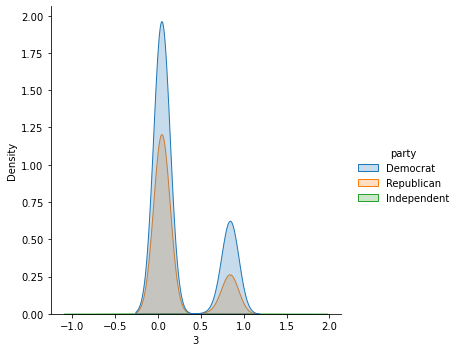

In [24]:
sns.displot(df_w_topics, x=df_w_topics[3], hue = "party", kind = 'kde', fill = 'true')
plt.show()

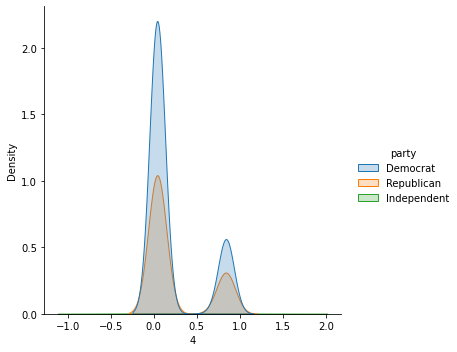

In [25]:
sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## 5. Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### 5.1: Tammy Duckworth (D-IL) vs. Ted Cruz (R-TX)

In [26]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))

#Ted Cruz and Tammy Duckworth Tweets
cruz_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Ted Cruz']
duckworth_tweets = congress_tweets[congress_tweets.name_wikipedia == "Tammy Duckworth"]

#Combining dataframes
cruz_duck_df = [cruz_tweets, duckworth_tweets]
cruz_duck_tweets = pd.concat(cruz_duck_df)

#Polarity and Subjectivity
cruz_duck_tweets['polarity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
cruz_duck_tweets['subjectivity'] = cruz_duck_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

cruz_duck_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count,polarity,subjectivity
820487,820487,1.279160e+18,SenTedCruz,2020-07-03T17:11:55-04:00,"This weekend, we celebrate the birth of our na...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","This weekend, we celebrate the birth of our na...",This weekend celebrate birth nation gift indep...,246,41,0.000000,0.000000
811947,811947,1.256300e+18,SenTedCruz,2020-05-01T15:29:55-04:00,RT @EricTrump Challenge accepted @SeanHannity!...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",RT @EricTrump Challenge accepted @SeanHannity!...,EricTrump Challenge accepted SeanHannity Along...,703,92,0.500000,0.600000
797929,797929,1.220850e+18,SenTedCruz,2020-01-24T18:29:25-05:00,My thoughts &amp; prayers are with the familie...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",My thoughts &amp; prayers are with the familie...,My thoughts prayers families 2 Houstonians liv...,688,84,-0.059524,0.238095
787860,787860,1.187810e+18,SenTedCruz,2019-10-25T15:26:23-04:00,It’s time for Congress and the American people...,Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843",It’s time for Congress and the American people...,It time Congress American people hear directly...,251,44,0.150000,0.225000
760177,760177,1.088950e+18,SenTedCruz,2019-01-25T18:47:06-05:00,"Yesterday, I fought hard to immediately pay ev...",Ted Cruz,Sen,3-Jan-13,12/22/1970,M,...,"4,685,047","3,877,868","3,308,124","4,569,843","Yesterday, I fought hard to immediately pay ev...",Yesterday I fought hard immediately pay single...,248,37,-0.090774,0.338988


### Polarity

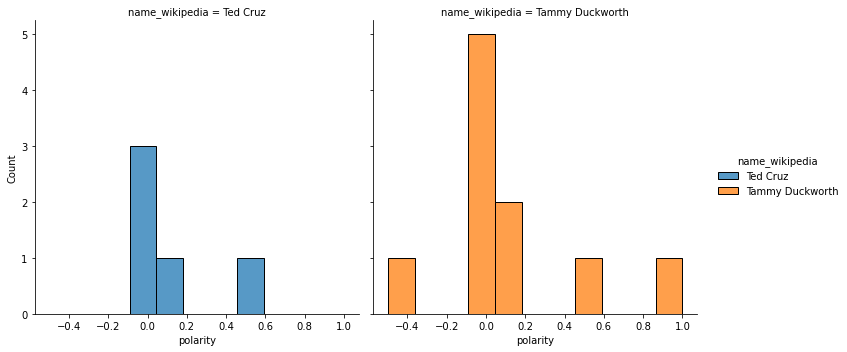

In [27]:
sns.displot(cruz_duck_tweets, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest polarity

**Tammy Duckworth:**

In [28]:
duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in duckworth_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

We can do so much more to help survivors of breast cancer return to health and achieve the best quality of life. That's why I'm introducing the Breast Cancer Patient Equity Act with @lisamurkowski, @RepJudyChu &amp; @RepWalorski https://www.duckworth.senate.gov/news/press-releases/-duckworth-murkowski-chu-and-walorski-re-introduce-bipartisan-bicameral-bill-to-expand-coverage-for-breast-cancer-patients-and-survivors



<ipython-input-28-647af7a0291e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['polarity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


**Ted Cruz:**

In [29]:
cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
for tweets in cruz_tweets.nlargest(1, "polarity")['text']:
    print(tweets + "\n")

RT @EricTrump Challenge accepted @SeanHannity! Along with the amazing team from @TrumpNationalNY, we are providing food to all police, firefighters and first responders in our town today! They are incredible men and women who have been in the front lines since the begining. @LaraLeaTrump https://twitter.com/seanhannity/status/1254552056347664384 QT @seanhannity Challenge met. I called my friend Randy Levine of the NY .@Yankees and  purchased 500 Yankee Tkts for The Hero medical workers all over NY. Randy and Hal Steinbrenner and the Yankees immediately donated 500 more tkts!! 

I now Challenge My friends
.@LaraLeaTrump  and .@EricTrump https://twitter.com/ainsleyearhardt/status/1253833611469520897



<ipython-input-29-0809f2072989>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['polarity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)


### Tweets with the smallest polarity

**Tammy Duckworth:**

In [30]:
for tweets in duckworth_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

Three years ago today, days after the horrific #PulseShooting, dozens of Congresspeople led by civil rights hero @repjohnlewis gathered on the House floor to stage an historic, 25-hour sit-in demanding a House vote to #EndGunViolence &amp; an end to GOP efforts to block those votes.



**Ted Cruz:**

In [31]:
for tweets in cruz_tweets.nsmallest(1, "polarity")['text']:
    print(tweets + "\n")

Yesterday, I fought hard to immediately pay every single essential federal employee – every essential employee at the Coast Guard, the TSA, air traffic controllers, Border Patrol agents, ICE agents, FBI agents, and those throughout law enforcement.



### Subjectivity

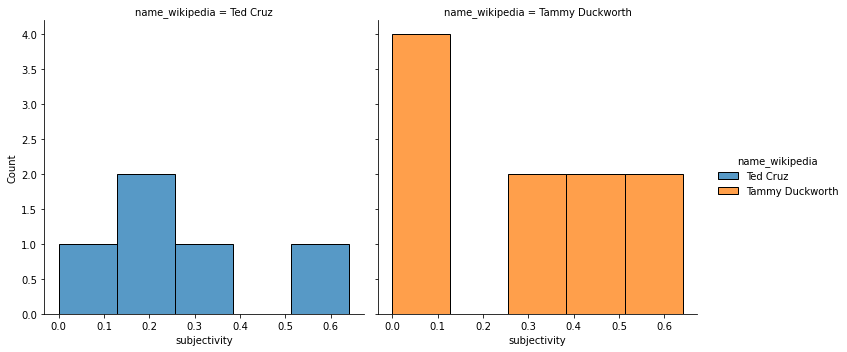

In [32]:
sns.displot(cruz_duck_tweets, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

### Tweets with the largest subjectivity

**Tammy Duckworth:**

In [33]:
duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in duckworth_tweets.nlargest(1, 'subjectivity')['text']:
    print(tweets + "\n")

I will keep working to ensure every family in America – no matter where they live – has access to clean and safe drinking water, and I’m proud to introduce this bill with @RepDanKildee to better protect our children from lead-contaminated water. https://www.duckworth.senate.gov/news/press-releases/07/11/2019/duckworth-kildee-re-introduce-legislation-to-help-protect-families-from-lead-contaminated-water



<ipython-input-33-5401f4840256>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duckworth_tweets['subjectivity'] = duckworth_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


**Ted Cruz**

In [34]:
cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
for tweets in cruz_tweets.nlargest(1, "subjectivity")['text']:
    print(tweets + "\n")

RT @EricTrump Challenge accepted @SeanHannity! Along with the amazing team from @TrumpNationalNY, we are providing food to all police, firefighters and first responders in our town today! They are incredible men and women who have been in the front lines since the begining. @LaraLeaTrump https://twitter.com/seanhannity/status/1254552056347664384 QT @seanhannity Challenge met. I called my friend Randy Levine of the NY .@Yankees and  purchased 500 Yankee Tkts for The Hero medical workers all over NY. Randy and Hal Steinbrenner and the Yankees immediately donated 500 more tkts!! 

I now Challenge My friends
.@LaraLeaTrump  and .@EricTrump https://twitter.com/ainsleyearhardt/status/1253833611469520897



<ipython-input-34-d66c643106dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cruz_tweets['subjectivity'] = cruz_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


### Tweets with the smallest subjectivity

**Tammy Duckworth:**

In [35]:
for tweets in duckworth_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

After my father lost his job when I was a teenager, food stamps and reduced price meals at school helped keep me from going hungry. I wasn’t alone, either: millions of children across our nation rely on #SchoolBreakfast and other nutritious meals too.



**Ted Cruz:**

In [36]:
for tweets in cruz_tweets.nsmallest(1, "subjectivity")['text']:
    print(tweets + "\n")

This weekend, we celebrate the birth of our nation and the gift of independence. Throughout the history of mankind, freedom has been the exception. And yet, here in America, freedom has been delivered and defended for every man, women, and child.



### Sujectivity vs. Polarity

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

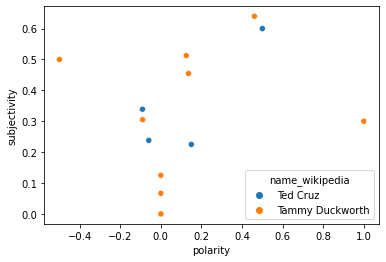

In [37]:
sns.scatterplot(x = cruz_duck_tweets['polarity'], y = cruz_duck_tweets['subjectivity'], hue = cruz_duck_tweets['name_wikipedia'])

### 5.2: Party Affiliation and Bodies of Congress

### Polarity 

In [38]:
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)

**Party Affiliation**

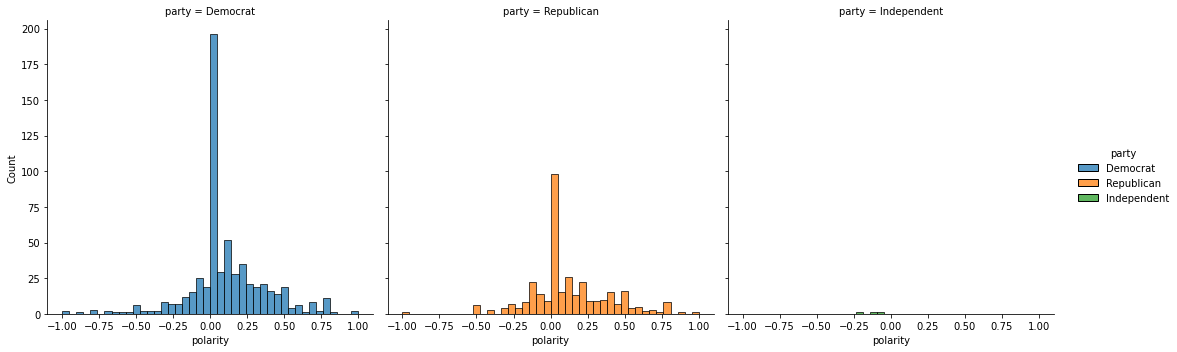

In [39]:
#By Party
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

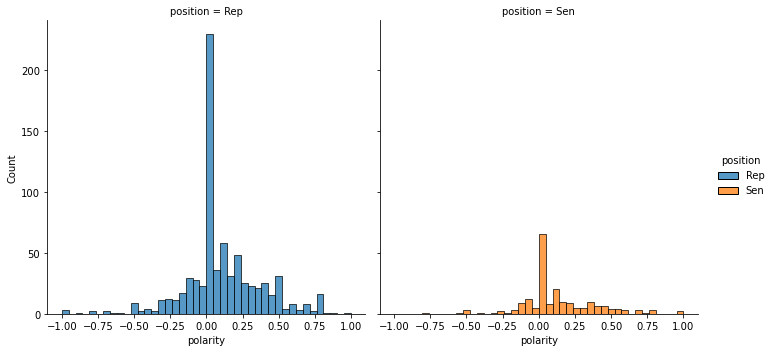

In [40]:
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.show()

### Subjectivity

In [41]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

**Party Affiliation**

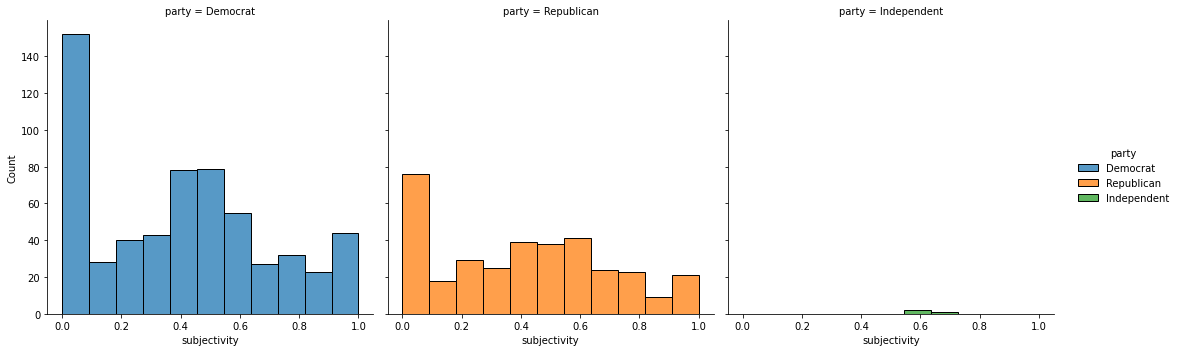

In [42]:
#by party
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

**Bodies of Congress**

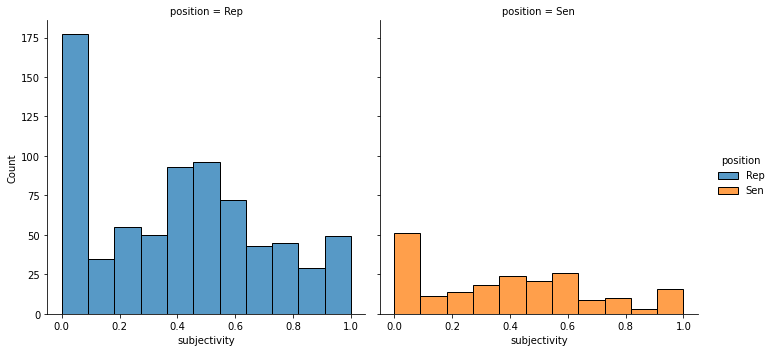

In [43]:
sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "position")
plt.show()

## 6. Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [44]:
# Engineered Features
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [45]:
countvec = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(2,3))
ngrams = countvec.fit_transform(congress_tweets['tokens'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

top_25_ngrams = dictionary_dataframe.loc[:,df_ngram[0:25]['ngrams']]


/Users/joseaveldanes/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [46]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [47]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)



tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

topic_dist = lda.transform(tfidf_matrix)
topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)


Topic #0:
need help    people house health country american legislation water work qt families new bill trump thank president proud federal

Topic #1:
work    time qt house americans families trump people thank — need members “ fill live health public week ”

Topic #2:
   covid19 trump president new qt continue people tax congress protect work workers time security de american – realdonaldtrump need

Topic #3:
act care    local president american crisis bill new health states immigration bipartisan legislation join qt senate ” communities work

Topic #4:
   community help thank trump covid19 happy read day new coronavirus house qt    senate act funding visit passed nt



In [48]:
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
nmf = NMF(n_components=5, init='random', random_state=0)
nmf = nmf.fit(dense_matrix)


tf_feature_names = tf.get_feature_names()
print_top_words(nmf, tf_feature_names, 20)

nmf_topic_dist = nmf.transform(tfidf_matrix)
nmf_topic_dist_df = pd.DataFrame(nmf_topic_dist).reset_index(drop = True)


Topic #0:
house senate passed act bill bipartisan time vote legislation    senatemajldr rights housedemocrats white ago people support government weeks floor

Topic #1:
care health need covid19 new help crisis small coronavirus businesses families relief    workers pandemic testing funding americans states federal

Topic #2:
de la y el en su del que o por sus ser las los una se entre estado para   

Topic #3:
trump president “ ” administration qt america realdonaldtrump — congress election people impeachment american mr stop country democrats said investigation

Topic #4:
thank work day veterans community great honor happy hall lives town nation week want    women questions family county live



In [49]:
congress_tweets.columns

Index(['index', 'tweet_id', 'screen_name', 'datetime', 'text',
       'name_wikipedia', 'position', 'joined_congress_date', 'birthday',
       'gender', 'state', 'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'text_deEmojify', 'tokens', 'tweet_len',
       'word_count', 'polarity', 'subjectivity'],
      dtype='object')

In [50]:
# Engineered Text Features
engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# Non-text features
non_text_features = congress_tweets[['position', 'joined_congress_date',
       'gender', 'state','party', 'trump_2016_state_share', 'clinton_2016_state_share']]
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

In [51]:
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
             top_25_ngrams,
             non_text_with_ngrams]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                           'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                          'Top 25 N-Gram Features',
                          'Non-Text + Top 25 N-Gram Features']

### Bag-of-words or Tf-idf

In [52]:
# Frequency Based featurization
...

In [53]:
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))

In [54]:
bow_matrix = bow_vector.fit_transform(congress_tweets['text_deEmojify'][0:5])

#bow_matrix = bow_vector.fit_transform(cfpb['Consumer complaint narrative'][0:5])

In [55]:
bow_matrix.todense()

matrix([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0

In [56]:
feature_names = bow_vector.get_feature_names()
feature_names[0:10]

[' ',
 '22',
 '27',
 'actonclimate',
 'alleviate',
 'answering',
 'arkansas',
 'askhank',
 'begun',
 'better']

### Word Embedding

In [57]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [58]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [59]:
# embedding based featurization
...

## 7. Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [60]:
congress_tweets.loc[congress_tweets['party'] == "Independent"]

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count,polarity,subjectivity
850253,850253,1.135930e+18,SenSanders,2019-06-04T11:41:20-04:00,I believe it is wrong to charge Americans astr...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,"95,369","178,573","199,239","92,698",I believe it is wrong to charge Americans astr...,I believe wrong charge Americans astronomical ...,384,36,-0.200000,0.600000
850782,850782,1.153670e+18,SenSanders,2019-07-23T10:27:29-04:00,Teachers are facing outrageous levels of stude...,Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,"95,369","178,573","199,239","92,698",Teachers are facing outrageous levels of stude...,Teachers facing outrageous levels student debt...,425,45,-0.066667,0.688889
849015,849015,1.089210e+18,SenSanders,2019-01-26T12:15:57-05:00,"Thank you air traffic controllers, flight atte...",Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,"95,369","178,573","199,239","92,698","Thank you air traffic controllers, flight atte...",Thank air traffic controllers flight attendant...,274,40,-0.125000,0.625000


In [61]:
congress_tweets['ReporDem'] = congress_tweets['party'].apply(lambda x: 0 if x=='Democrat' and x!='Independent' else 1)
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count,polarity,subjectivity,ReporDem
217331,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,...,"4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,Thank testifying Mr Blake QT JRBlake RepValDem...,233,30,0.000000,0.000000,0
258764,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,...,"1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,My Twitter Town Hall healthcare begun I m answ...,115,20,0.136364,0.500000,0
50091,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,...,"380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,Scipio Jones ‘ fight civil rights equality imp...,279,49,0.511111,0.833333,1
205601,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,...,"4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,There better time ActOnClimate EarthDay We rol...,158,27,0.450000,0.750000,0
85993,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,...,"8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,I understand VA problems recruiting qualified ...,202,32,0.000000,0.000000,1


In [62]:
congress_tweets.dtypes

index                         int64
tweet_id                    float64
screen_name                  object
datetime                     object
text                         object
name_wikipedia               object
position                     object
joined_congress_date         object
birthday                     object
gender                       object
state                        object
district_number              object
party                        object
trump_2016_state_share       object
clinton_2016_state_share     object
obama_2012_state_share       object
romney_2012_state_share      object
text_deEmojify               object
tokens                       object
tweet_len                     int64
word_count                    int64
polarity                    float64
subjectivity                float64
ReporDem                      int64
dtype: object

In [63]:
X

217331    Thank testifying Mr Blake QT JRBlake RepValDem...
258764    My Twitter Town Hall healthcare begun I m answ...
50091     Scipio Jones ‘ fight civil rights equality imp...
205601    There better time ActOnClimate EarthDay We rol...
85993     I understand VA problems recruiting qualified ...
                                ...                        
849015    Thank air traffic controllers flight attendant...
402238    LawrenceGenHosp new coronavirus community scre...
349360    senatemajldr If House musters courage stand sl...
65615     It important support policies promote public h...
356055    davidmgoodwin CDCgov It argument giving medica...
Name: tokens, Length: 947, dtype: object

In [64]:
# Engineered Text Features
engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

# Non-text features
non_text_features = congress_tweets[['position', 'joined_congress_date',
       'gender', 'state','party', 'trump_2016_state_share', 'clinton_2016_state_share']]
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

### First Set of Models Using Republican and Democrat Classifications

In [65]:
##train the Y and do the thing you need to do 
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
             top_25_ngrams,
             non_text_with_ngrams
             ]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                            'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                          'Top 25 N-Gram Features',
                          'Non-Text + Top 25 N-Gram Features']
                          
lb_style = LabelBinarizer()
y = lb_style.fit_transform(congress_tweets["ReporDem"])

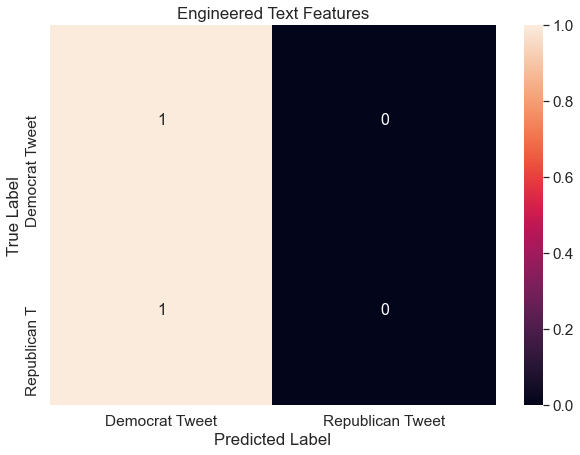

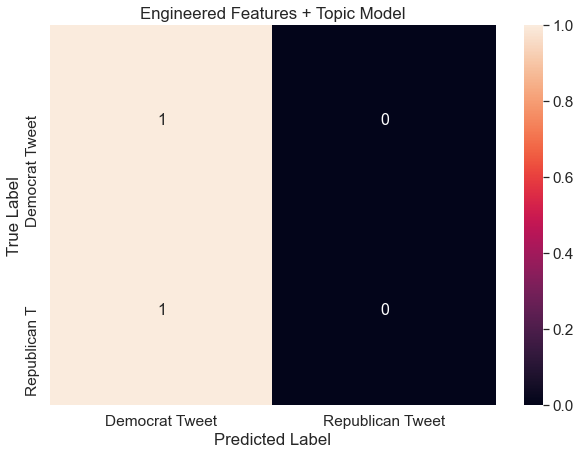

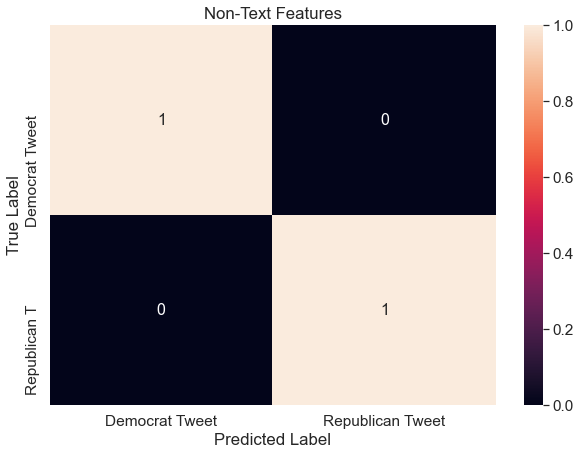

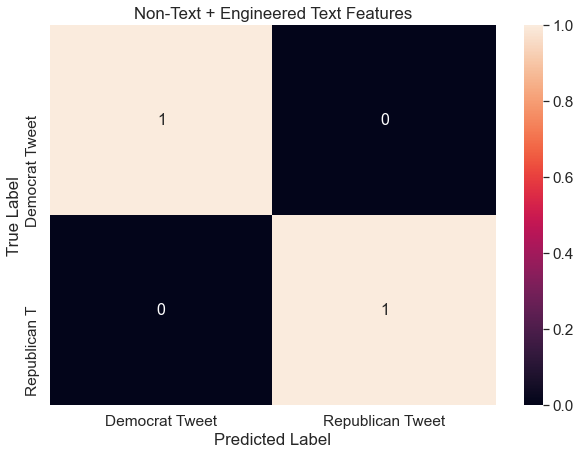

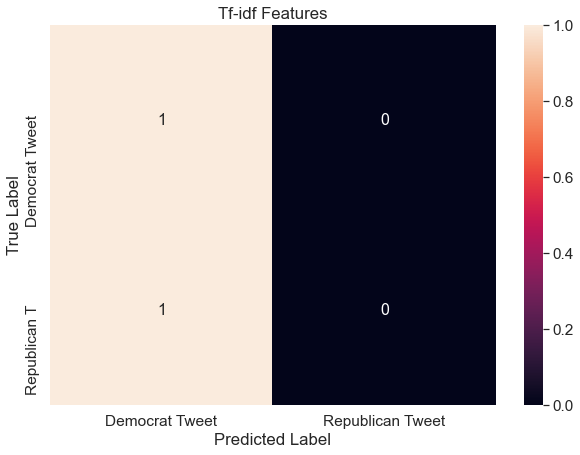

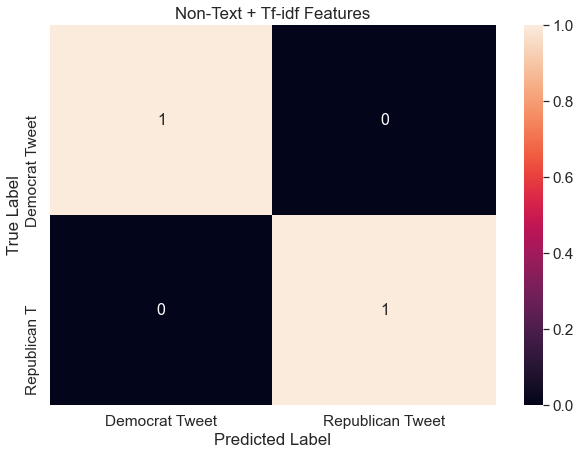

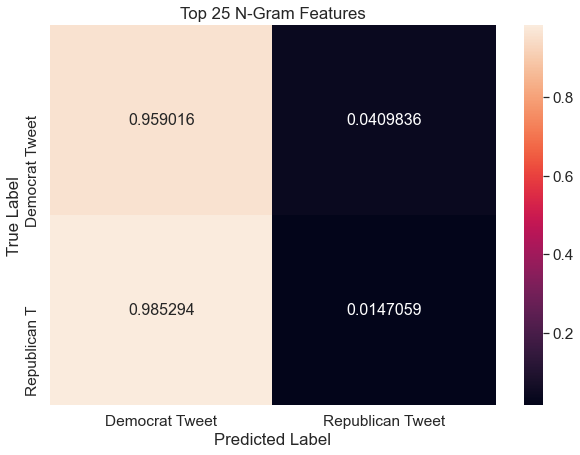

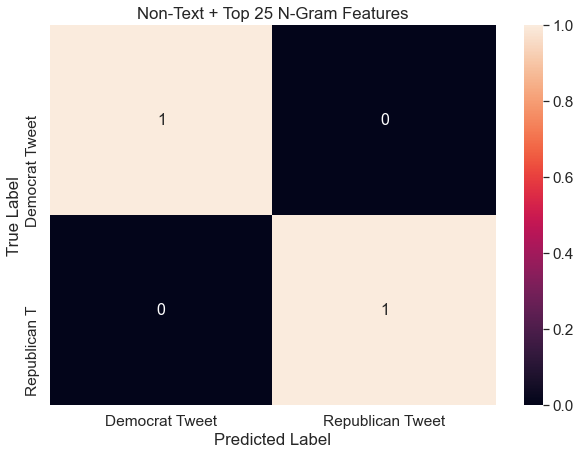

In [80]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

##There are the first three models with democrat and republican 
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression(max_iter=200)
    
    # fit the model
    logit_model = logit_reg_extra.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Democrat Tweet", 1: "Republican Tweet"})
    df_cm.index = ["Democrat Tweet", "Republican T"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [98]:
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count,polarity,subjectivity,ReporDem
217331,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,...,"4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,Thank testifying Mr Blake QT JRBlake RepValDem...,233,30,0.000000,0.000000,0
258764,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,...,"1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,My Twitter Town Hall healthcare begun I m answ...,115,20,0.136364,0.500000,0
50091,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,...,"380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,Scipio Jones ‘ fight civil rights equality imp...,279,49,0.511111,0.833333,1
205601,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,...,"4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,There better time ActOnClimate EarthDay We rol...,158,27,0.450000,0.750000,0
85993,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,...,"8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...,I understand VA problems recruiting qualified ...,202,32,0.000000,0.000000,1


### Visualize the relationship between polarity and subjectivity in the corpus to see if results make sense

<AxesSubplot:xlabel='polarity', ylabel='subjectivity'>

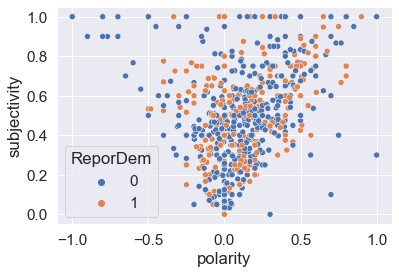

In [86]:
sns.scatterplot(x = congress_tweets['polarity'], y = congress_tweets['subjectivity'], hue = congress_tweets['ReporDem'])

### Second Set of Models Using Senator and Representative Classifications

In [100]:
##train the Y for the second set of models with senator/representative classifications
dataframes = [engineered_features, 
              engineered_features_with_topics,
              non_text_features_dummies,
              non_text_engineered_features,
              tfidf_df, 
              non_text_plus_tfidf,
             top_25_ngrams,
             non_text_with_ngrams
             ]

featurization_technique = ['Engineered Text Features',
                            'Engineered Features + Topic Model',
                           'Non-Text Features',
                           'Non-Text + Engineered Text Features',
                            'Tf-idf Features',
                           'Non-Text + Tf-idf Features',
                          'Top 25 N-Gram Features',
                          'Non-Text + Top 25 N-Gram Features']
                          
lb_style = LabelBinarizer()
y = congress_tweets['SenorRep'] = lb_style.fit_transform(congress_tweets["position"])

In [102]:
##here I am checking to make sure that "SenorRep" did what I needed it to do for the classification process
congress_tweets

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,...,obama_2012_state_share,romney_2012_state_share,text_deEmojify,tokens,tweet_len,word_count,polarity,subjectivity,ReporDem,SenorRep
217331,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,...,"4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...,Thank testifying Mr Blake QT JRBlake RepValDem...,233,30,0.000000,0.000000,0,0
258764,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,...,"1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...,My Twitter Town Hall healthcare begun I m answ...,115,20,0.136364,0.500000,0,0
50091,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,...,"394,409","647,744",Scipio Jones‘ fight for civil rights and equal...,Scipio Jones ‘ fight civil rights equality imp...,279,49,0.511111,0.833333,1,0
205601,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,...,"4,237,756","4,163,447",There is no better time to #ActOnClimate than ...,There better time ActOnClimate EarthDay We rol...,158,27,0.450000,0.750000,0,0
85993,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,...,"7,854,285","4,839,958",I understand the VA often has problems recruit...,I understand VA problems recruiting qualified ...,202,32,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849015,849015,1.089210e+18,SenSanders,2019-01-26T12:15:57-05:00,"Thank you air traffic controllers, flight atte...",Bernie Sanders,Sen,3-Jan-07,9/8/1941,M,...,"199,239","92,698","Thank you air traffic controllers, flight atte...",Thank air traffic controllers flight attendant...,274,40,-0.125000,0.625000,1,1
402238,402238,1.240730e+18,RepLoriTrahan,2020-03-19T16:09:06-04:00,.@LawrenceGenHosp has two new #coronavirus com...,Lori Trahan,Rep,3-Jan-19,10/27/1973,F,...,"1,921,290","1,188,314",.@LawrenceGenHosp has two new #coronavirus com...,LawrenceGenHosp new coronavirus community scre...,325,35,0.178788,0.618182,0,0
349360,349360,1.213200e+18,McConnellPress,2020-01-03T15:42:15-05:00,RT @senatemajldr If the House ever musters the...,Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,...,"679,370","1,087,190",RT @senatemajldr If the House ever musters the...,senatemajldr If House musters courage stand sl...,222,37,0.000000,0.000000,1,1
65615,65615,1.108480e+18,RepDeSaulnier,2019-03-20T17:20:11-04:00,It has never been more important to support po...,Mark DeSaulnier,Rep,3-Jan-15,3/31/1952,M,...,"7,854,285","4,839,958",It has never been more important to support po...,It important support policies promote public h...,426,42,0.200000,0.533333,0,0


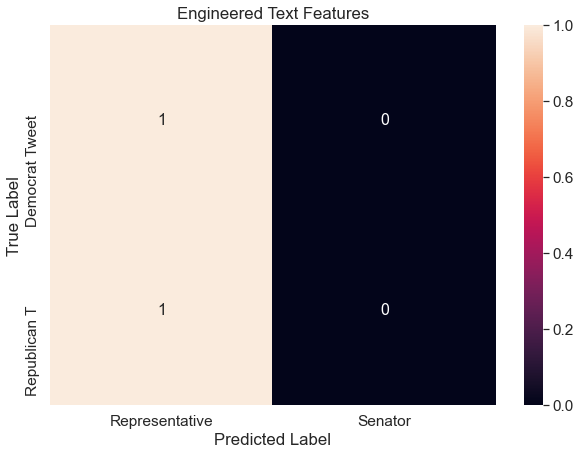

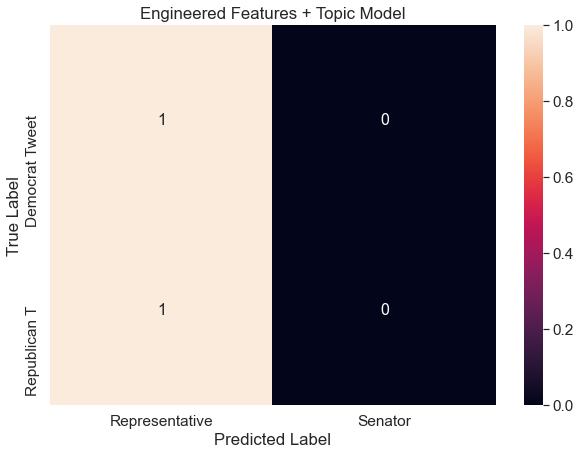

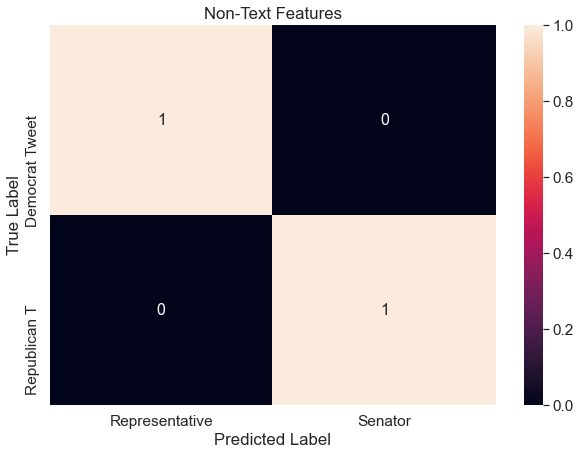

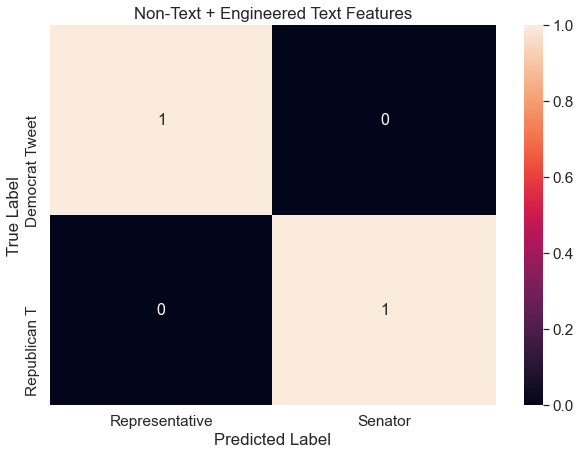

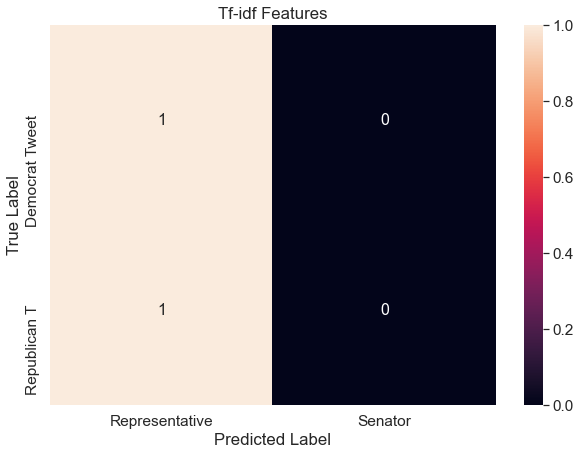

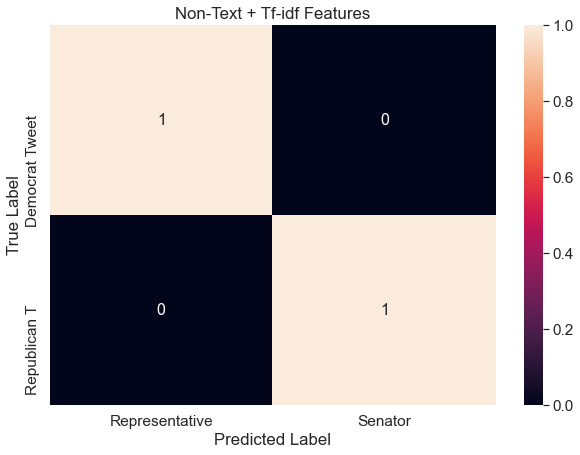

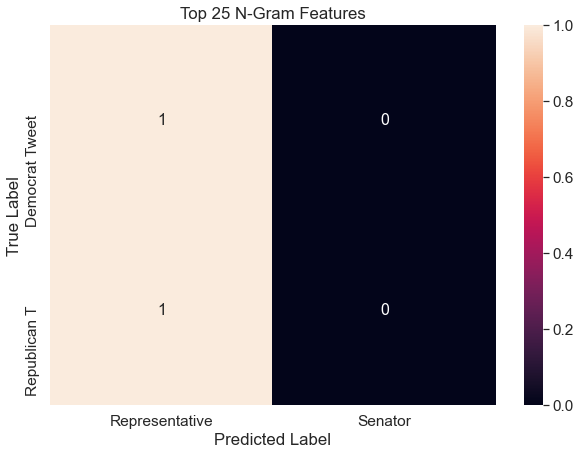

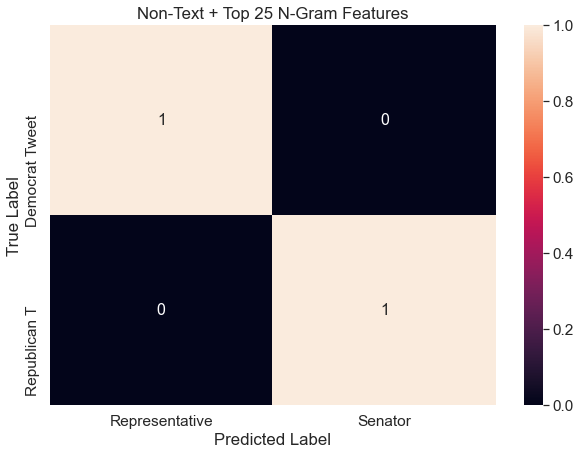

In [105]:
# second set of models models ([engineered features, frequency-based, embedding] * senator/representative])

##There are the first three models with democrat and republican 
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression(max_iter=200)
    
    # fit the model
    logit_model = logit_reg_extra.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Democrat Tweet", "Republican T"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])


...

## 8. Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**